# Training a Classifier (CNN) Datasets- EMNIST

We will use the EMNIST dataset.


*   EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
*   EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
*   EMNIST Balanced:  131,600 characters. 47 balanced classes.
*   EMNIST Letters: 145,600 characters. 26 balanced classes.
*   EMNIST Digits: 280,000 characters. 10 balanced classes.
*   EMNIST MNIST: 70,000 characters. 10 balanced classes.


The images in EMNIST are of
size 1x28x28, i.e. 1-channel color(grey) images of 28x28 pixels in size.

In [2]:
from google.colab import drive
drive.mount('/content/drive') #掛載你的雲端硬碟到colab上的路徑

Mounted at /content/drive


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.transforms import Pad

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 12 08:38:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [7]:
# EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
# 圖片進來時先做padding 上下左右都填充4個值為0的pixel，然後再隨機裁減圖片為28*28
# 接著圖片值為[0~255]之間，經過ToTensor後(就是每一個像素除以255)值就變為[0~1]之間
# 最後在再根據 RGB 做 normalize， mean = (0.4914, 0.4822, 0.4465), stddev = (0.2023, 0.1994, 0.2010) <- 這些值是根據cifar10 training dataset 所算出來的


# 這區塊就是Data augmentation
transform = transforms.Compose([ 
    lambda img : transforms.functional.rotate(img,-90),
    lambda img : transforms.functional.hflip(img),
    transforms.RandomCrop(28, padding=2),
    # transforms.RandomResizedCrop(28, scale=(0.6, 0.8)),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5)), # EMNIST原本就是灰階
])

# Number of Train: 697932, Number of Test: 116323
trainSet = torchvision.datasets.EMNIST(root="data/", split="byclass", download=True, train=True, transform=transform)              
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=512, shuffle=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


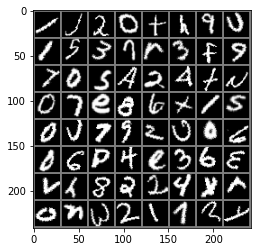

images shape:  torch.Size([512, 1, 28, 28])
labels shape:  torch.Size([512])


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
for i, data in enumerate(trainLoader, 1):
  images, labels = data
  break

imshow(torchvision.utils.make_grid(images[0:64]))
print("images shape: " ,images.shape)
print("labels shape: " ,labels.shape)

Total No of Images in EMNIST dataset: 814255
No of images in Training dataset:     697932
No of images in Testing dataset:      116323
No of classes:  62
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# Output func = (X + 2*padding - kernal)/ stride+1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn_conv1 = nn.BatchNorm2d(64)
        self.bn_conv2 = nn.BatchNorm2d(64)
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.bn_conv4 = nn.BatchNorm2d(128)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 62)
        # self.conv1 = nn.Conv2d(1, 64, 5, padding=1)
        # self.conv2 = nn.Conv2d(64, 64, 5, padding=1)
        # self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.bn_conv1 = nn.BatchNorm2d(64)
        # self.bn_conv2 = nn.BatchNorm2d(64)
        # self.bn_conv3 = nn.BatchNorm2d(64)
        # self.bn_conv4 = nn.BatchNorm2d(64)
        # self.bn_dense1 = nn.BatchNorm1d(1024)
        # self.bn_dense2 = nn.BatchNorm1d(512)
        # self.dropout_conv = nn.Dropout2d(p=0.25)
        # self.dropout = nn.Dropout(p=0.5)
        # self.fc1 = nn.Linear(64 * 6 * 6, 1024)
        # self.fc2 = nn.Linear(1024, 512)
        # self.fc3 = nn.Linear(512, 62)

    def conv_layers(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))
        out = F.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        out = F.relu(self.bn_conv3(self.conv3(out)))
        out = F.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        return out

    def dense_layers(self, x):
        out = F.relu(self.bn_dense1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn_dense2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        out = self.conv_layers(x)
        #print(out.shape)
        out = out.view(-1, 128 * 7 * 7)
        # out = out.view(x[0].shape, -1)
        out = self.dense_layers(out)
        return out

net = Net()
net.to(device)
print(net)
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropout2d(p

In [18]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [53]:
net.train()
loss_hist, acc_hist = [], []

net.train()
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    for data in tqdm(trainLoader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainSet)
    avg_acc = correct / len(trainSet)
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)
    print("Epoch: {}, train_avg_loss: {}, train_avg_acc: {}".format(epoch+1, avg_loss, avg_acc))
    

100%|██████████| 1364/1364 [05:35<00:00,  4.06it/s]


Epoch: 1, train_avg_loss: 0.0013885728706444927, train_avg_acc: 0.7679286807310741


100%|██████████| 1364/1364 [05:36<00:00,  4.05it/s]


Epoch: 2, train_avg_loss: 0.0010202117454503278, train_avg_acc: 0.8181943226560754


100%|██████████| 1364/1364 [05:36<00:00,  4.05it/s]


Epoch: 3, train_avg_loss: 0.0009636458180263668, train_avg_acc: 0.8265275127089745


100%|██████████| 1364/1364 [05:35<00:00,  4.06it/s]


Epoch: 4, train_avg_loss: 0.0009393477580383402, train_avg_acc: 0.8306410939747711


100%|██████████| 1364/1364 [05:39<00:00,  4.02it/s]


Epoch: 5, train_avg_loss: 0.0009141510597670207, train_avg_acc: 0.8342517609165363


100%|██████████| 1364/1364 [05:32<00:00,  4.10it/s]


Epoch: 6, train_avg_loss: 0.0009022199688097932, train_avg_acc: 0.8357261165844238


100%|██████████| 1364/1364 [05:33<00:00,  4.09it/s]


Epoch: 7, train_avg_loss: 0.0008916279068829173, train_avg_acc: 0.8376933569459489


100%|██████████| 1364/1364 [05:33<00:00,  4.08it/s]


Epoch: 8, train_avg_loss: 0.0008801408378289195, train_avg_acc: 0.8394155877649971


100%|██████████| 1364/1364 [05:34<00:00,  4.08it/s]


Epoch: 9, train_avg_loss: 0.0008710338124935346, train_avg_acc: 0.84091573391104


100%|██████████| 1364/1364 [05:40<00:00,  4.00it/s]

Epoch: 10, train_avg_loss: 0.0008657344942869492, train_avg_acc: 0.8418585191680565


In [10]:
PATH = './drive/MyDrive/Colab Notebooks/hw3_improve.pth'

In [55]:
# 存模型參數
net.to(device)
torch.save(net.state_dict(), PATH)

In [11]:
#讀模型參數（讀回來）
# net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
# 這區塊就是Data augmentation
transform_test = transforms.Compose([ 
    lambda img : transforms.functional.rotate(img,-90),
    lambda img : transforms.functional.hflip(img),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5)), # EMNIST原本就是灰階
])
testSet = torchvision.datasets.EMNIST(root="data/", split="byclass", download=True, train=False, transform=transform_test)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=100, shuffle=True)

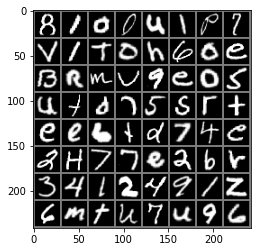

In [13]:
# get some random training images
for i, data in enumerate(testLoader, 1):
  test_images, test_labels = data
  break

imshow(torchvision.utils.make_grid(test_images[0:64]))

In [19]:
# Test
correct = 0
total = 0
class_correct = [0 for i in range(62)]
class_total = [0 for i in range(62)]

net.eval()
for i, data in enumerate(testLoader, 1):
    with torch.no_grad():
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            # print(class_correct)
            # print(class_total)

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))
acc=[]
for i in range(62):
    acc.append(class_correct[i]/class_total[i])
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 1 %
Accuracy of 0: 0.000000
Accuracy of 1: 0.000000
Accuracy of 2: 0.000000
Accuracy of 3: 0.000000
Accuracy of 4: 0.000000
Accuracy of 5: 0.000000
Accuracy of 6: 0.000000
Accuracy of 7: 0.000000
Accuracy of 8: 0.000000
Accuracy of 9: 0.000000
Accuracy of 10: 0.000000
Accuracy of 11: 0.000000
Accuracy of 12: 1.000000
Accuracy of 13: 0.000000
Accuracy of 14: 0.000000
Accuracy of 15: 0.000000
Accuracy of 16: 0.000000
Accuracy of 17: 0.000000
Accuracy of 18: 0.000000
Accuracy of 19: 0.000000
Accuracy of 20: 0.000000
Accuracy of 21: 0.000000
Accuracy of 22: 0.000000
Accuracy of 23: 0.000000
Accuracy of 24: 0.000000
Accuracy of 25: 0.000000
Accuracy of 26: 0.000000
Accuracy of 27: 0.000000
Accuracy of 28: 0.000000
Accuracy of 29: 0.000000
Accuracy of 30: 0.000000
Accuracy of 31: 0.000000
Accuracy of 32: 0.000000
Accuracy of 33: 0.000000
Accuracy of 34: 0.000000
Accuracy of 35: 0.000000
Accuracy of 36: 0.000000
Accuracy of 37: 0.000000
Accura

In [ ]:
print(testLoader)

In [ ]:
loss_hist

[0.0010586668239089359,
 0.0008238229338249064,
 0.0007831061783204374,
 0.0007614964454037112,
 0.0007465050252744051,
 0.0007334273715946157,
 0.0007206328581253904,
 0.0007118137903022557,
 0.0007023015496601103,
 0.000692828604390251]

In [20]:
loss_hist=[0.0013885728706444927, 0.0010202117454503278, 0.0009636458180263668, 0.0009393477580383402, 0.0009141510597670207, 
 0.0009022199688097932, 0.0008916279068829173,  0.0008801408378289195,0.0008710338124935346, 0.0008657344942869492]

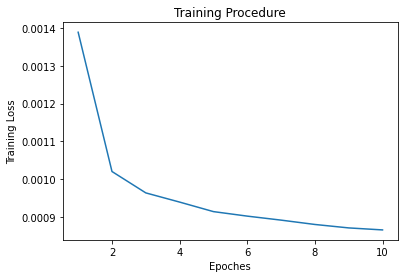

In [21]:
import matplotlib.pyplot as plt
x=np.array([1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Epoches')
plt.ylabel('Training Loss')
plt.title('Training Procedure')

plt.plot(x,loss_hist)
plt.show()